## Tratamento dos dados

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Phishing_Email.csv", encoding='latin-1')

df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [23]:
df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns={"Email Text": "texto"})
print(df["Email Type"].value_counts())
print("Total: ", df["Email Type"].value_counts().sum())

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64
Total:  18650


In [24]:
df["texto"].replace('empty',np.nan,inplace=True)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_13420\1425109582.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["texto"].replace('empty',np.nan,inplace=True)


In [25]:
df = df.dropna()
print(df.value_counts().sum())
df

18101


,texto,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18644,\nRick Moen a ÃÂ©crit:> > I'm confused. I th...,Safe Email
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email


In [26]:
df = df.drop_duplicates(subset='texto', keep='first')
print(df.value_counts().sum())

17536


In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

C:\Users\Samuel\AppData\Local\Temp\ipykernel_13420\3829774040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Email Type"] = le.fit_transform(df["Email Type"])


In [28]:
import unicodedata
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.category(c) == 'Mn'])

def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word not in ENGLISH_STOP_WORDS])

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = remove_accents(text)
    text = remove_stopwords(text)
    return text.strip()

df["texto"] = df["texto"].apply(preprocess_text)

print(df.head())


                                               texto  Email Type
0  6 1100 disc uniformitarianism 1086 sex lang di...           1
1  galicismos galicismo spanish term names improp...           1
2  equistar deal tickets available assist robert ...           1
3  hello hot lil horny toy dream open minded pers...           0
4  software incredibly low prices 86 lower draper...           0


C:\Users\Samuel\AppData\Local\Temp\ipykernel_13420\77995477.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["texto"] = df["texto"].apply(preprocess_text)


In [29]:
from gensim.models import Word2Vec

def word2vec(textos_tokenizados, vector_size=200, window=6, min_count=2):
    model = Word2Vec(
        sentences=textos_tokenizados,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=1,
        workers=4
    )
    return model

def vetor_medio(texto, model):
    palavras = texto.split()
    vetores = [model.wv[p] for p in palavras if p in model.wv]
    if vetores:
        return np.mean(vetores, axis=0)
    else:
        return np.zeros(model.vector_size)

def word2vec_transform(df, model):
    vetores = df["texto"].apply(lambda x: vetor_medio(x, model))
    matriz = np.vstack(vetores.values)

    df_w2v = pd.DataFrame(matriz, columns=[f"w2v_{i}" for i in range(model.vector_size)])
    df_w2v["Email Type"] = df["Email Type"].values

    return df_w2v, model

df["tokens"] = df["texto"].apply(lambda x: x.lower().split())

modelo_w2v = word2vec(df["tokens"].tolist())

df_final, modelo_w2v = word2vec_transform(df, modelo_w2v)

print(df_final.head())


C:\Users\Samuel\AppData\Local\Temp\ipykernel_13420\951628509.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"] = df["texto"].apply(lambda x: x.lower().split())


      w2v_0     w2v_1     w2v_2     w2v_3     w2v_4     w2v_5     w2v_6  \
0  0.157792  0.095785  0.041907  0.055599  0.192339 -0.195438  0.072391   
1  0.229039  0.023426 -0.082124  0.080695  0.153122 -0.099686  0.037389   
2 -0.068323  0.193124 -0.072639 -0.161856 -0.035922 -0.323268  0.216972   
3  0.095870  0.000636  0.030991 -0.004970  0.235921 -0.210779 -0.026588   
4  0.255144  0.056666  0.093812  0.033531  0.258994 -0.146027  0.036313   

      w2v_7     w2v_8     w2v_9  ...   w2v_191   w2v_192   w2v_193   w2v_194  \
0  0.461395 -0.068914 -0.069236  ... -0.030238 -0.114249 -0.188712 -0.002301   
1  0.374224 -0.123337 -0.101575  ... -0.076615 -0.012668 -0.192912 -0.087016   
2  0.491613 -0.020305 -0.223151  ...  0.041504 -0.057866 -0.473140 -0.050923   
3  0.350057 -0.033460 -0.020268  ...  0.034435 -0.145337 -0.170842 -0.029763   
4  0.451245 -0.104977  0.001867  ...  0.042628 -0.094796 -0.226291  0.012707   

    w2v_195   w2v_196   w2v_197   w2v_198   w2v_199  Email Type  
0 

## Rede Neural

### Criação sem K-fold 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


X = df_final.drop(columns=["Email Type"])
y = df_final["Email Type"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=777)

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(8, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid')) 

optimizer = optimizers.SGD(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))



c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 8)              │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649 (6.44 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 0 (0.00 B)

None


c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5689 - loss: 0.6848

c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5692 - loss: 0.6847 - val_accuracy: 0.6379 - val_loss: 0.6446
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6689 - loss: 0.6305 - val_accuracy: 0.8186 - val_loss: 0.5712
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8636 - loss: 0.5457 - val_accuracy: 0.9330 - val_loss: 0.4532
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9358 - loss: 0.4227 - val_accuracy: 0.9448 - val_loss: 0.3474
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9456 - loss: 0.3265 - val_accuracy: 0.9508 - val_loss: 0.2788
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9504 - loss: 0.2623 - val_accuracy: 0.9540 - val_loss: 0.2347
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9519 - loss: 0.2260 - val_accuracy: 0.9555 - val_loss: 0.2046
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9537 - loss: 0.2067 - val_accurac

c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy on Test Set: 0.9652223489167617
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1304
           1       0.97      0.97      0.97      2204

    accuracy                           0.97      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.97      0.97      0.97      3508



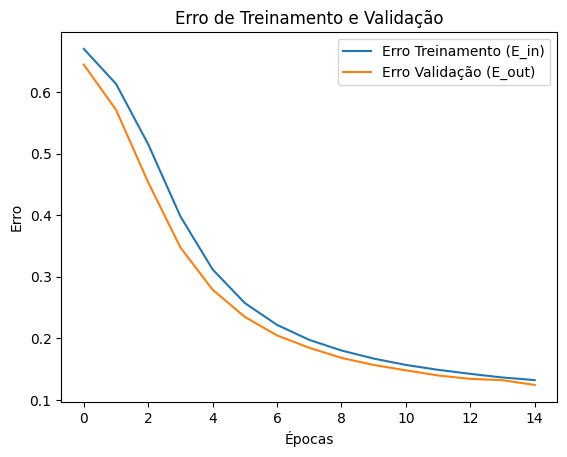

c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Erro de Treinamento (E_in): 0.1279
Erro de Validação/Teste (E_out): 0.1299


c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Acurácia no Treinamento: 0.9639


c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Acurácia no Teste: 0.9652


In [35]:
# Erro de Treinamento e Validação
plt.plot(history.history['loss'], label='Erro Treinamento (E_in)')
plt.plot(history.history['val_loss'], label='Erro Validação (E_out)')
plt.title('Erro de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend()
plt.show()

E_in = model.evaluate(X_train, y_train, verbose=0)[0]
E_out = model.evaluate(X_test, y_test, verbose=0)[0]

print(f"\nErro de Treinamento (E_in): {E_in:.4f}")
print(f"Erro de Validação/Teste (E_out): {E_out:.4f}")

loss_train, acc_train = model.evaluate(X_train, y_train, verbose=0)
print(f"Acurácia no Treinamento: {acc_train:.4f}")

loss_test, acc_test = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no Teste: {acc_test:.4f}")


### Com K-fold

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

X = df_final.drop(columns=["Email Type"]).values
y = df_final["Email Type"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

BATCH_SIZE = 32
EPOCHS = 20
input_dim = X_train.shape[1]


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_idx, val_idx in skf.split(X_train, y_train):
    print(f"Treinando Fold {fold}...")

    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = optimizers.SGD(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(X_train_fold, y_train_fold,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        verbose=1)

    fold += 1

final_model = Sequential()
final_model.add(Dense(8, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'))
final_model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("\nTreinando modelo final...")
final_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n==== Avaliação no conjunto de Teste ====")
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))


Treinando Fold 1...


c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Samuel\Desktop\ML-PLN\ml_project\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6345 - loss: 0.6629 - val_accuracy: 0.6200 - val_loss: 0.6319
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6285 - loss: 0.6172 - val_accuracy: 0.6245 - val_loss: 0.5846
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6515 - loss: 0.5646 - val_accuracy: 0.7024 - val_loss: 0.5146
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7498 - loss: 0.4961 - val_accuracy: 0.8174 - val_loss: 0.4400
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8292 - loss: 0.4218 - val_accuracy: 0.8486 - val_loss: 0.3715
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8735 - loss: 0.3554 - val_accuracy: 0.8971 - val_loss: 0.3089
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9039 - loss: 0.3018 - val_accuracy: 0.9176 - val_loss: 0.2598
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9187 - loss: 0.2605 - v

KeyboardInterrupt: 

## Salvando modelo

In [36]:
import joblib
joblib.dump(model, 'modelo_phishing.pkl')  

loaded_model = joblib.load('modelo_phishing.pkl')  


In [37]:
loaded_model = joblib.load('modelo_phishing.pkl')

## Testando o modelo

In [38]:
df_emails = pd.DataFrame({
    "texto": [
        # 1 - Phishing
        """Subject: Urgent: Account Verification Required

Dear Customer,

Our system has detected an issue with your account. To prevent it from being suspended, please verify your information through the link below:

[Verify Account Now]

Failure to do so within 24 hours will result in a permanent lock.

Thank you for your prompt attention to this matter.

Account Security Team
""",
        # 2 - Phishing
        """Subject: Immediate Action Needed: Suspicious Login Activity

Dear User,

We noticed a suspicious login attempt from a new device. If this wasn’t you, please verify your account immediately by clicking on the secure link below:

[Secure Your Account]

Regards,
Security Team
""",
        # 3 - Phishing
        """Subject: You Have A Pending Payment Request

Dear Customer,

There is an outstanding payment of $225.48 on your account that needs to be cleared immediately. Click the link below to make your payment and avoid penalties:

[Pay Now]

Failure to act within 48 hours may result in account restrictions.

Best regards,
Billing Department
""",
        # 4 - Phishing
        """Subject: Your Shipment Is On Hold: Immediate Action Needed

Dear Shopper,

We attempted to deliver your recent order, but there was an issue with the shipping address. To avoid delays, please confirm your address by clicking on the link below:

[Confirm Address]

We appreciate your cooperation.

Shipping Department
""",
        # 5 - Phishing
        """Subject: You Won $500! Confirm Your Prize Now

Dear Winner,

Congratulations! You’ve won a $500 Amazon gift card. Please confirm your details by clicking the link below to claim your prize:

[Claim Your Prize]

Don’t miss out – offer expires soon!

Best,
Prize Notification Team
""",
        # 6 - Não Phishing
        """Subject: Meeting Agenda for Upcoming Strategy Session

Hello Team,

I’ve attached the agenda for our upcoming strategy session scheduled for next Tuesday at 9 AM. Please take a moment to review the topics before the meeting.

Looking forward to our discussion!

Best regards,
Strategy Team
""",
        # 7 - Não Phishing
        """Subject: Reminder: Time-Off Requests for Upcoming Holidays

Dear Employee,

This is a friendly reminder to submit your time-off requests for the upcoming holiday season. Ensure your requests are submitted by the deadline to allow for scheduling adjustments.

Let HR know if you need assistance.

Best regards,
Human Resources
""",
        # 8 - Não Phishing
        """Subject: Invitation to the Charity Fundraiser Event

Dear Team,

We are hosting our annual charity fundraiser on May 15th, and we would love for you to join us in supporting a good cause. The event will be held at City Hall, starting at 6 PM.

Please RSVP if you plan to attend.

Best,
Event Coordination Team
""",
        # 9 - Não Phishing
        """Subject: New Employee Onboarding Materials

Dear New Hire,

Welcome to the team! Attached, you’ll find all the necessary onboarding documents and instructions for your first day. Please review everything before your start date.

We’re excited to have you onboard!

Best regards,
HR Team
""",
        # 10 - Não Phishing
        """Subject: Invitation to Participate in Wellness Program

Dear Staff,

We are excited to announce the launch of our new wellness program designed to promote healthy living. You’re invited to join us for an introductory session on Monday at 3 PM.

We look forward to your participation!

Best,
Wellness Program Team
"""
    ]
})



for idx, texto in enumerate(df_emails["texto"]):
    texto_preprocessado = preprocess_text(texto)
    
    vetor_novo = vetor_medio(texto_preprocessado, modelo_w2v)
    X_novo = np.array([vetor_novo])
    
    y_pred_prob = model.predict(X_novo)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    print(f"\nEmail {idx+1}:")
    if y_pred[0][0] == 0:
        print("Classe prevista: Phishing")
    else:
        print("Classe prevista: Não Phishing")
    
    print("Probabilidade de ser Não Phishing:", round(float(y_pred_prob[0][0]), 4))
    print("Probabilidade de ser Phishing:", round(1 - float(y_pred_prob[0][0]), 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Email 1:
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.0957
Probabilidade de ser Phishing: 0.9043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Email 2:
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.446
Probabilidade de ser Phishing: 0.554
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

Email 3:
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.0105
Probabilidade de ser Phishing: 0.9895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Email 4:
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.0715
Probabilidade de ser Phishing: 0.9285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Email 5:
Classe prevista: Phishing
Probabilidade de ser Não Phishing: 0.0137
Probabilidade de ser Phishing: 0.9863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

Email 6:
Classe prevista: Não Phishing
Probabilidade de ser Não Phishing: 0.9479
Probabilidade de ser Phishing: 0.0521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Email 7:
Classe prevista: Não Phis